In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import re
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
# parse hands based on participant
def parse_participant_hands(X, y, filenames, participant, exercise=""):
    # extracts a participants hands from a given set of X, y data and a list of filenames
    # optionally extract a specfic exercise from the data
    
    r = re.compile(participant + exercise)

    # remove p data
    vmatch = np.vectorize(lambda x:bool(r.search(x)))
    p_files = vmatch(filenames)

    return X[p_files], y[p_files], filenames[p_files]

In [4]:
def split_static(X, y, f):
    # remove p#s data
    r = re.compile('p[\d]s')
    vmatch = np.vectorize(lambda x: bool(r.search(x)))
    rem_static = vmatch(f)

    X_nos, y_nos, f_nos = X[~rem_static], y[~rem_static], f[~rem_static]
    X_s, y_s, f_s = X[rem_static], y[rem_static], f[rem_static]

    return X_nos, y_nos, f_nos, X_s, y_s, f_s

In [13]:
def average_participant_results(results, k_folds=3):
    
    acc = 0
    f_score = 0
    conf_mat = np.zeros((3,3), dtype="int")
    
    for i in range(k_folds):
        acc += results["cv{}_accuracy".format(i)]
        f_score += results["cv{}_f_score".format(i)]
       
        # dealing with different size confusion matrices / shouldn't be larger than 3,3
        cm = np.array(results["cv{}_conf_mat".format(i)], dtype="int")
        idx_y = conf_mat.shape[0] - cm.shape[0]
        idx_x = conf_mat.shape[1] - cm.shape[1]
        conf_mat[:-idx_y or None, :-idx_x or None] += cm
        
    return acc / k_folds, f_score / k_folds, conf_mat

In [14]:
def average_experiment_results(results, participants, k_folds=3):
    
    exp_acc = 0
    exp_f = 0
    exp_cm = np.zeros((3,3), dtype="int")
    
    for p in participants:
        acc, f_score, cm = average_participant_results(results[p], k_folds)
        exp_acc += acc
        exp_f += f_score
        
        diff_x = (exp_cm.shape[1] - cm.shape[1]) * -1
        diff_y = (exp_cm.shape[0] - cm.shape[0]) * -1
        exp_cm[:diff_y or None,:diff_x or None] += cm
        
    return exp_acc / len(participants), exp_f / len(participants), exp_cm

In [5]:
hands = np.load("data/hands/hands-M5-rad0.15-pall.npz")

In [6]:
participants = ["p1", "p3", "p4", "p6"]

In [7]:
# Get hands and labels from the compressed numpy file
lhs = hands["lh_dmaps"]
y_lh = hands["y_lh"]

rhs = hands["rh_dmaps"]
y_rh = hands["y_rh"]

filenames = hands["filenames"]

assert lhs.shape == y_lh.shape == rhs.shape == y_rh.shape == filenames.shape

In [8]:
print("Left Hand Info\t", lhs.shape, lhs.dtype)
print("   Labels Info\t", y_lh.shape, y_lh.dtype)
print("Rght Hand Info\t", rhs.shape, rhs.dtype)
print("   Labels Info\t", y_rh.shape, y_rh.dtype)
print("Filename Info\t", filenames.shape, filenames.dtype)

Left Hand Info	 (15817,) object
   Labels Info	 (15817,) int64
Rght Hand Info	 (15817,) object
   Labels Info	 (15817,) int64
Filename Info	 (15817,) <U30


In [9]:
# combine rh and lh for training a single model
hands_comb = np.hstack((lhs, rhs))
y = np.hstack((y_lh, y_rh))
files_comb = np.hstack((filenames, filenames))

# rem static
hands_comb, y, files_comb, _, _, _ = split_static(hands_comb, y, files_comb)

assert hands_comb.shape == y.shape == files_comb.shape, "Error combining hands.  Array shapes are different sizes"

In [10]:
for p in participants:
    
    print("Particpant {}".format(p))
    p_hands, p_y, p_files = parse_participant_hands(hands_comb, y, files_comb, p)
    print("\tLabel 0:", p_y[p_y==0].shape)
    print("\tLabel 1:", p_y[p_y==1].shape)
    print("\tLabel 2:", p_y[p_y==2].shape)
    print()

Particpant p1
	Label 0: (6011,)
	Label 1: (162,)
	Label 2: (1021,)

Particpant p3
	Label 0: (3917,)
	Label 1: (1336,)
	Label 2: (47,)

Particpant p4
	Label 0: (2262,)
	Label 1: (3376,)
	Label 2: (0,)

Particpant p6
	Label 0: (6111,)
	Label 1: (286,)
	Label 2: (27,)



In [55]:
smotes = ["regular", "borderline1", "borderline2", "svm", "adasyn", "none"]

results = {}
for i, s in enumerate(smotes):
    results[s] = np.load("results/honv_smote_results/cmj_exp-smote_results_{}.pkl".format(i+1))

In [56]:
accs, fs, cms = [], [], []

for s in smotes:

    r = results[s]

    exp_accs, exp_fs, exp_cms = [], [], []

    for p in participants:
        acc, f_score, cm = average_participant_results(r[p])

        exp_accs.append(acc)
        exp_fs.append(f_score)
        exp_cms.append(cm)

    accs.append(exp_accs)
    fs.append(exp_fs)
    cms.append(exp_cms)

accs = np.array(accs)
fs = np.array(fs)
cms = np.array(cms)

l = len(accs)

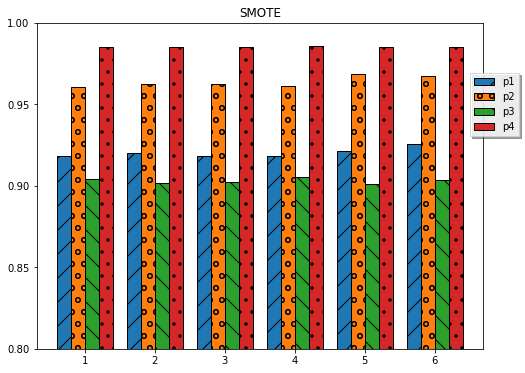

In [57]:
idx = np.arange(l) + 1
width = .2

plt.figure(figsize=(8,6))
plt.ylim([.85, 1.0])
plt.yticks(np.linspace(.8, 1.0, 5))
# plt.xticks(idx,["128x128", "90x160", "130x190", "96x96"])

plt.title("SMOTE")
plt.bar(idx-(width*1+width/2), fs[:,0], width, hatch="/", edgecolor='black')
plt.bar(idx-(width*0+width/2), fs[:,1], width, hatch="o", edgecolor='black')
plt.bar(idx+(width*1-width/2), fs[:,2], width, hatch="\\", edgecolor='black')
plt.bar(idx+(width*2-width/2), fs[:,3], width, hatch=".", edgecolor='black')
plt.legend(["p1", "p2", "p3", "p4"], loc='center left', bbox_to_anchor=(.96, 0.75), fancybox=False, shadow=True)

In [58]:
plt.figure(figsize=(12, 10))
for i, cm in enumerate(cms):
    print(cm[0])
#     cm_total = np.sum(cm, axis=0)
#     cm_total = cm_total.astype('float') / cm_total.sum(axis=1)[:, np.newaxis]
#     plt.subplot(1, 5, i+1)
#     plt.imshow(cm_total, cmap="Blues")

[[5680   28  303]
 [  69   89    4]
 [ 190    0  831]]
[[5688   22  301]
 [  66   92    4]
 [ 186    0  835]]
[[5684   23  304]
 [  71   87    4]
 [ 190    0  831]]
[[5688   23  300]
 [  67   90    5]
 [ 198    0  823]]
[[5797   11  203]
 [  68   91    3]
 [ 266    0  755]]
[[5812   14  185]
 [  64   94    4]
 [ 254    0  767]]


In [46]:
smote_avgs = np.average(accs, axis=1)

In [47]:
print(smote_avgs)

[ 0.94312472  0.94361864  0.94326513  0.94379531  0.94764399]
